# Using EcoFOCIpy to apply Data Filters to 1D data

- filter examples:
    - 35hr Lanzcos Filter **good for data with tides like ADCP**
    - IQR (inter-quartile range) filter
    - STD (standard deviation) filter
    - 7pt rolling mean-value exceeds 10std of timeseries demeaned data **good for spiky data like chlor**
    
    
- input:
    - timeseries data
- output:
    - timeseries data
    
TODO:
- output to xarray modified netcdf file

In [1]:
import xarray as xa
import numpy as np
import matplotlib.pyplot as plt
import datetime

import EcoFOCIpy.math.cleaning as cleaning #<- instrument specific
import EcoFOCIpy.math.lanzcos as lanzcos #<- instrument specific

In [6]:
# testfile = '../staticdata/example_data/nc_data/16bsm2a_eco_0000m.nc'
testfile = '/Users/bell/ecoraid/2017/Moorings/17bs5a/erddap/final_data/17bs5a_ecf_0016m.cf.nc'

So lets load a timeseries and apply filters to the entire period

In [7]:
xdf = xa.load_dataset(testfile)
xdf

<xarray.Dataset>
Dimensions:        (depth: 1, lat: 1, lon: 1, time: 9019)
Coordinates:
  * time           (time) datetime64[ns] 2017-09-28T01:00:00 ... 2018-10-08T1...
  * depth          (depth) float32 16.0
  * lat            (lat) float32 59.91
  * lon            (lon) float32 171.7
Data variables:
    fluor_3031     (time, depth, lat, lon) float32 363.2 377.9 ... 433.7 400.9
    fluorstd_2031  (time, depth, lat, lon) float32 9.122 15.11 ... 17.4 13.44
    Fch_906        (time, depth, lat, lon) float32 2.223 2.328 ... 2.724 2.491
Attributes: (12/14)
    CREATION_DATE:        August 04, 2021 19:50 UTC
    COMPOSITE:            1
    INST_TYPE:            eco
    DATA_CMNT:            17bs5a_flsb_3074_18m.txt
    EPIC_FILE_GENERATOR:  nc_epic2udunits_time.py V0.4.0
    PROG_CMNT01:          
    ...                   ...
    MOORING:              17bs5a
    WATER_MASS:           
    EXPERIMENT:           
    PROJECT:              
    History:              \nNovember 01, 2018 21:03 UTC Data Trimmed\n\nAugus...
    featureType:

In [17]:
#data without flags or set to large numbers... especially if not nan or EPIC
xdf = xdf.where(xdf<1e20,np.nan)

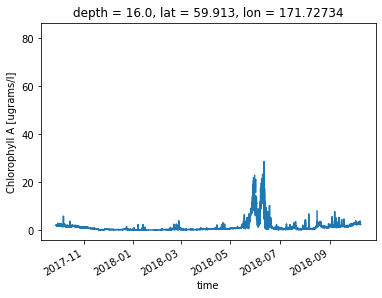

In [18]:
xdf.Fch_906.plot()

In [14]:
df = xdf.Fch_906[:,0,0,0].to_dataframe().drop(labels=['depth','lat','lon'],axis=1)
dft = df.dropna()
#
## missing data fill limited by number of hours to linearly interpolate
temp = dft['Fch_906'].interpolate(method='time',limit=6)

# get index of missing data that wasn't filled
# the remaining missing data will continue to be missing after analysis
# this data and the edges of the timeseries need to have the effects of the filter window accounted for

missing_index = np.isnan(temp)
temp = dft['Fch_906'].interpolate(method='time')

#address gaps at beginning and end... back fill... and forward fill at end... 
# the filter window will correct small gaps at the tails but will become worse as the leading gaps get bigger
temp.bfill(inplace=True)
temp.ffill(inplace=True)

#filter data with lanzcos filter
lanzcosfiltered = lanzcos.lanzcos(temp.values,1,35) + dft['Fch_906'].mean()

In [10]:
IQRcleaned = cleaning.outlier_bounds_iqr(xdf.Fch_906)
STDcleaned = cleaning.outlier_bounds_std(xdf.Fch_906)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1550: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


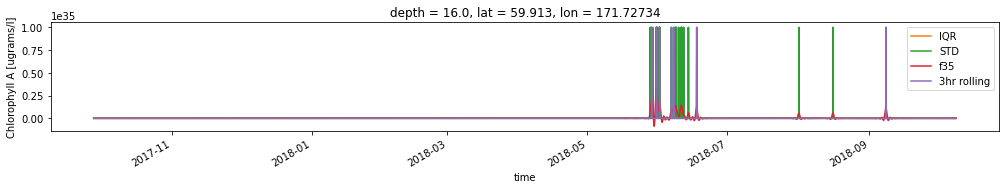

In [11]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf.Fch_906.plot(ax=ax)
((xdf.Fch_906 * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf.Fch_906 * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf.Fch_906[:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median().Fch_906.plot(label='3hr rolling', ax=ax)

ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf.Fch_906.plot(ax=ax)
((xdf.Fch_906 * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf.Fch_906 * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf.Fch_906[:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median().Fch_906.plot(label='3hr rolling', ax=ax)
xdf.rolling(time=3, center=True).construct('tmp').quantile(.25, dim='tmp').Fch_906.plot(label='3hr rolling quantile', ax=ax)

ax.legend()
ax.set_xlim([datetime.date(2018,5,22),datetime.date(2018,6,20)])

So none of the previous filters are particularly useful here as the spike is large and short in time

- apply a 24hr rolling filter

In [ ]:
r = (xdf.Fch_906 - xdf.rolling(time=3, center=True).median().Fch_906)
rc = cleaning.outlier_bounds_std(r,10)

In [ ]:
(xdf.Fch_906 - xdf.rolling(time=7, center=True).mean().Fch_906).plot(label='3hr rolling')
((xdf.Fch_906 * 0) + rc).plot(label='std')


In [ ]:
fig, ax = plt.subplots(figsize=(17, 2))

xdf.Fch_906.plot(ax=ax)
((xdf.Fch_906 * 0) + IQRcleaned).plot(label='IQR',ax=ax)
((xdf.Fch_906 * 0) + STDcleaned).plot(label='STD',ax=ax)
((xdf.Fch_906[:,0,0,0] * 0) + lanzcosfiltered).plot(label='f35',ax=ax)
xdf.rolling(time=3, center=True).median().Fch_906.plot(label='3hr rolling', ax=ax)
xdf.Fch_906.where(~np.isnan(rc)).plot(label='7hr rolling variance', ax=ax)

ax.legend()
ax.set_xlim([datetime.date(2018,5,22),datetime.date(2018,6,20)])